# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 



### Содержание
### [1. Подготовка данных](#section_id1)
### [2. Исследование задачи](#section_id2)
### [3. Борьба с дисбалансом](#section_id3)
### [4. Тестирование модели](#section_id4)
### [5. Вывод](#section_id5)

<a id='section_id1'></a>

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


1. Средний возраст и возраст примерно одинаков и составляет 37 - 39 лет (минимальный возраст 18 лет, максимальный 92 года, что вполне вписывается в рамки).Распределение примерно симметричное.
2. Кол-во недвижимости варьируется от 0 до 10 (среднее и медиана равны).
3. У 25% клиентов на балансе фигурирует ноль, и скорее всего они кандидаты, чтобы покинуть банк Бетта.
4. Интересный факт, что существует клиент, у которого зарплата равняется 11,58 условным единицам при средней в 100 тыс у.е.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видим, что у 1000 клиентов отсутствуют данные по недвижимости (можем удалить, но тогда мы потеряем 10% данных о клиенте, учитывая то, что в других столбцах с данными все нормально, так что лучше оставим)

In [5]:
data['CustomerId'].value_counts()

15812607    1
15741078    1
15635776    1
15740223    1
15738174    1
           ..
15743714    1
15639265    1
15641312    1
15684319    1
15695872    1
Name: CustomerId, Length: 10000, dtype: int64

Дубликатов по id нет, каждая строка уникальная

In [6]:
#проверим данные на мультиколлинеарность
data.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Сильной зависимости признаков мы не видим, поэтому удалить какой-либо из столбцов мы не имеем права. Однаком мы видим, что при увеличении возраста, риск покинуть банк выше. Также наблюдаем отрицательную корреляцию активности клиента с признаком ухода из банка (чем клиент активнее, тем ниже шанс покинуть банк).

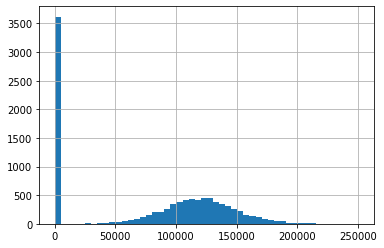

In [7]:
data['Balance'].hist(bins=50)

Не считая нулевые значения, значения на гистограмме распределены равномерно. Также нельзя исключать клиентов с нулевыми балансами (как раз таки они и первые кандидаты, чтобы покинуть банк)

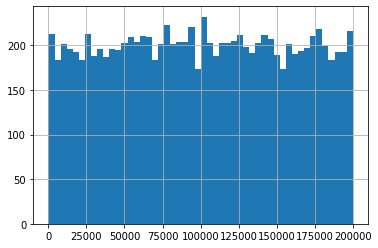

In [8]:
data['EstimatedSalary'].hist(bins=50)

In [9]:
#необходимо также привести наименование столбцов к строчному виду
data.columns = data.columns.str.lower()

Также для выполнения нашей задачи можно исключить столбцы surname, customerid и tenure (т.к. зависимость фамилии от ухода из банка маловероятна да и корреляция кол-ва недвижимости от ухода из банка практические нулевая)

In [10]:
new_data = data.drop(['surname', 'customerid', 'tenure'], axis=1)

<a id='section_id2'></a>

# 2. Исследование задачи

In [11]:
#проведем прямое кодирование для нахождения лучшей модели, чтобы f1 была > 0.59 
#(во избежание дамми-ловушки, удалим исохдные столбцы)
df_dum = pd.get_dummies(new_data, drop_first=True)
df_dum.head()

,rownumber,creditscore,age,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,1,619,42,0.00,1,1,1,101348.88,1,0,0,0
1,2,608,41,83807.86,1,0,1,112542.58,0,0,1,0
2,3,502,42,159660.80,3,1,0,113931.57,1,0,0,0
3,4,699,39,0.00,2,0,0,93826.63,0,0,0,0
4,5,850,43,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
#разобьем наш таблицу на 2 части на признаки и целевые признаки
features = df_dum.drop(['exited'], axis=1)
target = df_dum['exited']

In [13]:
#разделим выборку на обучающую и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state = 123456)

In [14]:
#разделим выборку на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state = 123456)

In [15]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)
(6000,)
(2000,)
(2000,)


In [16]:
#с помощью функции изучим класс балансов
def class_balance (features_train, target_train):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    return (features_zeros, features_ones, target_zeros, target_ones)

In [17]:
features_zeros, features_ones, target_zeros, target_ones = class_balance(features_train, target_train)
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4786, 11)
(1214, 11)
(4786,)
(1214,)


Видим, что имеется дисбаланс (отношение единиц к нулю 1:4). В 3 главе разберем данный вопрос подробнее

In [18]:
#перед началом обучения, проведем масштабирование признаков, чтобы все признаки были значимыми
numeric = ['creditscore', 'age', 'numofproducts', 'estimatedsalary']

In [19]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])#настройка модели (вычисление среднего и дисперсии)
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
print(features_valid.head(3))

      rownumber  creditscore       age    balance  numofproducts  hascrcard  \
1517       1518     0.976989  1.434858   93806.31       0.800273          0   
2016       2017     0.478729 -1.049938  172646.82      -0.917665          1   
3972       3973    -1.182137 -1.623352   89492.62      -0.917665          0   

      isactivemember  estimatedsalary  geography_Germany  geography_Spain  \
1517               1         0.709394                  0                0   
2016               1         0.299425                  0                0   
3972               0        -0.978170                  0                0   

      gender_Male  
1517            1  
2016            1  
3972            0  


Привели все данные к единому виду (мат ожидание 0 и дисперсия 1)

In [21]:
#исследуем модель решающее дерево меняя глубину дерева
for i in range(1,9):
    model = DecisionTreeClassifier(random_state = 123456, max_depth = i)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)#предсказание
    print(f'max_depth = {i}:', end=' ')
    print('f1-мера =', f1_score(target_valid, predictions_valid))

max_depth = 1: f1-мера = 0.0
max_depth = 2: f1-мера = 0.5078864353312303
max_depth = 3: f1-мера = 0.530232558139535
max_depth = 4: f1-мера = 0.49501661129568103


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


max_depth = 5: f1-мера = 0.5049504950495048
max_depth = 6: f1-мера = 0.5392592592592592
max_depth = 7: f1-мера = 0.5417867435158502
max_depth = 8: f1-мера = 0.5544267053701016


In [22]:
def auc_roc_chart(features_valid, target_valid, title):#данной функцией будем строить график auc_roc
    probabilities_valid = model.predict_proba(features_valid)#предсказание через вероятности
    probabilities_one_valid = probabilities_valid[:, 1]#вероятности предсказания только истинных значений
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    #строим график
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Площадь под кривой = ', auc_roc)

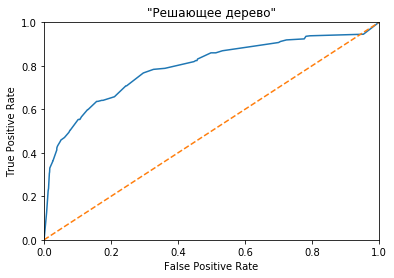

Площадь под кривой =  0.7935447282398584


In [23]:
auc_roc_chart(features_valid, target_valid, '"Решающее дерево"')

Модель "решающее дерево" не обеспечивает точность f1-меры > 0.59. Максимульная точность получается при глубине дерева равной 5, далее модель просто переобучается

In [24]:
#используем модель случайный лес
for i in range(1,10,2):
    for j in range(1,40,5):
        model = RandomForestClassifier(max_depth=i, n_estimators=j, random_state=123456)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        if (f1_score(target_valid, predictions_valid) > 0.52):
            print(f'max_depth = {i}:', end=' ')
            print(f'n_estimators = {j}:', end=' ')
            print('f1-мера = ', f1_score(target_valid, predictions_valid))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

max_depth = 9: n_estimators = 6: f1-мера =  0.5329052969502408
max_depth = 9: n_estimators = 11: f1-мера =  0.5303514376996805
max_depth = 9: n_estimators = 16: f1-мера =  0.5365079365079365
max_depth = 9: n_estimators = 21: f1-мера =  0.5390749601275917
max_depth = 9: n_estimators = 26: f1-мера =  0.5488958990536277
max_depth = 9: n_estimators = 31: f1-мера =  0.5344
max_depth = 9: n_estimators = 36: f1-мера =  0.5408000000000001


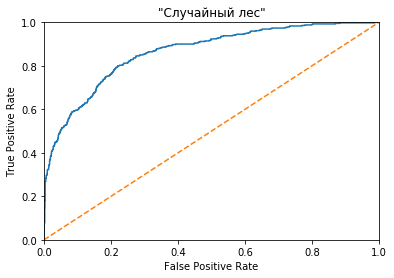

Площадь под кривой =  0.8631075322034


In [25]:
auc_roc_chart(features_valid, target_valid, '"Случайный лес"')

Модель "решающее дерево" показал лучшую точность f1-меры, чем "случайный лес" (0.55 > 0.44). Гиперпараметр как class_weight не применялся. Однако площадь под кривой у случайного леса лучше, т.е. решающее дерево по f1 мере лучше за счет полноты (т.е. очень мало ложноотрицательных ответов). Проверим модель "логистическая регрессия".

In [26]:
#используем модель логистическая регрессия
for i in range(1,10,2):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=i)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print(f'max_iter = {i}:', end=' ')
    print('f1-мера = ', f1_score(target_valid, predictions_valid))

max_iter = 1: f1-мера =  0.5408000000000001
max_iter = 3: f1-мера =  0.5408000000000001


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


max_iter = 5: f1-мера =  0.5408000000000001
max_iter = 7: f1-мера =  0.5408000000000001
max_iter = 9: f1-мера =  0.5408000000000001


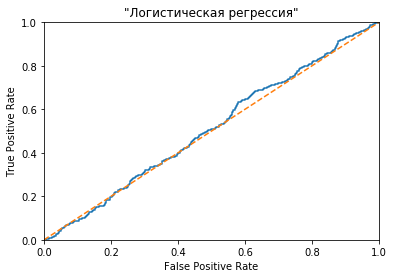

Площадь под кривой =  0.5097125424401927


In [27]:
auc_roc_chart(features_valid, target_valid, '"Логистическая регрессия"')

На данном этапе нами были проведены решение моделей "решающее дерево", "случайны лес" и "логистическая регресии". Метрика f1-мера показала лучший результат при решающем дереве, однако площадь под кривой в случайном лесе больше, чем в решающем дереве (случайный лес предсказывал лучше точность, а решающее дерево полноту). Но на данном этапе классы были несбалансированными и применять решающее дерево я бы не стал, тем более, что поставленную задачу мы не выполнили. Также отношение клиентов которые покинут банк к клиентам которые остаются, соотносятся как 1:4

<a id='section_id3'></a>

# 3. Борьба с дисбалансом

На данном этапе нужно улучшить метрику f1. Для этого нужно проверить все способы по борьбе с дисбалансом 
(произвести взвешивание классов, увеличение положительной выборки, уменьшение отрицательной выборки).

## Увеличение выборки

In [28]:
#напишем функцию, которая увеличивает положительную выборку (новые не создаются, а просто дублируются существующие
#и перемешиваются)
def upsample(features, target, repeat):
    features_zeros, features_ones, target_zeros, target_ones = class_balance (features, target)
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    #print(target_upsampled.value_counts())
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=123456)
    return features_upsampled, target_upsampled

In [29]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)#так как отношение 1/4
print(features_upsampled.shape)
print(target_upsampled.shape)

(9642, 11)
(9642,)


In [30]:
#для решающего дерева
for i in range(1,8):
    model = DecisionTreeClassifier(random_state = 123456, max_depth = i)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)#предсказание
    print(f'max_depth = {i}:', end=' ')
    print('f1-мера =', f1_score(target_valid, predictions_valid))

max_depth = 1: f1-мера = 0.4947867298578199
max_depth = 2: f1-мера = 0.5285451197053407
max_depth = 3: f1-мера = 0.5285451197053407
max_depth = 4: f1-мера = 0.555350553505535
max_depth = 5: f1-мера = 0.5433962264150943
max_depth = 6: f1-мера = 0.5510388437217706
max_depth = 7: f1-мера = 0.5582655826558265


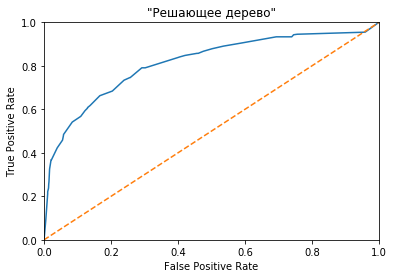

Площадь под кривой =  0.8130066685821479


In [31]:
auc_roc_chart(features_valid, target_valid, '"Решающее дерево"')

При глубине дерева max_depth=5, f1-мера на валидационной выборке показывает 0,5985. Также площадь под кривой стало значительно лучше. Проверим остальные модели.

In [32]:
#используем модель случайный лес
for i in range(1,15,2):
    for j in range(1,100,5):
        model = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=2, random_state=123456)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        if (f1_score(target_valid, predictions_valid) > 0.61):
            print(f'max_depth = {i}:', end=' ')
            print(f'n_estimators = {j}:', end=' ')
            print('f1-мера = ', f1_score(target_valid, predictions_valid))

max_depth = 5: n_estimators = 16: f1-мера =  0.6103012633624879
max_depth = 5: n_estimators = 21: f1-мера =  0.6136363636363636
max_depth = 5: n_estimators = 51: f1-мера =  0.6156824782187802
max_depth = 5: n_estimators = 56: f1-мера =  0.6168768186226963
max_depth = 5: n_estimators = 61: f1-мера =  0.6120434353405726
max_depth = 5: n_estimators = 66: f1-мера =  0.6137254901960785
max_depth = 5: n_estimators = 71: f1-мера =  0.6128078817733991
max_depth = 5: n_estimators = 81: f1-мера =  0.6149312377210217
max_depth = 5: n_estimators = 86: f1-мера =  0.6125244618395304
max_depth = 5: n_estimators = 96: f1-мера =  0.6112759643916914
max_depth = 7: n_estimators = 21: f1-мера =  0.6160164271047227
max_depth = 7: n_estimators = 26: f1-мера =  0.6133333333333333
max_depth = 7: n_estimators = 31: f1-мера =  0.6177685950413223
max_depth = 7: n_estimators = 36: f1-мера =  0.6138002059732235
max_depth = 7: n_estimators = 41: f1-мера =  0.6174358974358973
max_depth = 7: n_estimators = 46: f1-мер

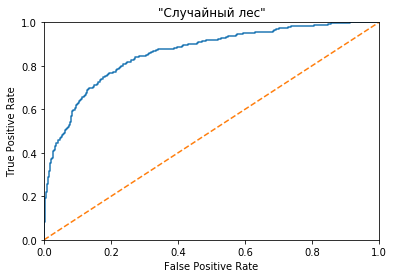

Площадь под кривой =  0.8600981709160762


In [33]:
auc_roc_chart(features_valid, target_valid, '"Случайный лес"')

Случайный лес показал более лучшую точность метрики f1 при сбалансированных признаках нежели при несбалансированных и сделал это более точнее, чем решающее дерево. Проверим логистическую регрессию по баланса.

In [34]:
#используем модель логистическая регрессия
for i in range(1,100,5):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=i)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    print(f'max_iter = {i}:', end=' ')
    print('f1-мера = ', f1_score(target_valid, predictions_valid))

max_iter = 1: f1-мера =  0.6233453670276775
max_iter = 6: f1-мера =  0.6233453670276775


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


max_iter = 11: f1-мера =  0.6233453670276775
max_iter = 16: f1-мера =  0.6233453670276775
max_iter = 21: f1-мера =  0.6233453670276775
max_iter = 26: f1-мера =  0.6233453670276775
max_iter = 31: f1-мера =  0.6233453670276775
max_iter = 36: f1-мера =  0.6233453670276775
max_iter = 41: f1-мера =  0.6233453670276775
max_iter = 46: f1-мера =  0.6233453670276775
max_iter = 51: f1-мера =  0.6233453670276775
max_iter = 56: f1-мера =  0.6233453670276775
max_iter = 61: f1-мера =  0.6233453670276775
max_iter = 66: f1-мера =  0.6233453670276775
max_iter = 71: f1-мера =  0.6233453670276775
max_iter = 76: f1-мера =  0.6233453670276775
max_iter = 81: f1-мера =  0.6233453670276775
max_iter = 86: f1-мера =  0.6233453670276775
max_iter = 91: f1-мера =  0.6233453670276775
max_iter = 96: f1-мера =  0.6233453670276775


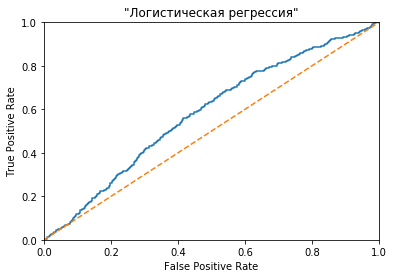

Площадь под кривой =  0.5812738150216845


In [35]:
auc_roc_chart(features_valid, target_valid, '"Логистическая регрессия"')

Метрику f1 логистическая регрессия показала схожую со случайным лесом, но ввиду маленькой площади под кривой, случайный лес будет лучше. Проверим как ведут себя модели в уменьшении отрицательной выборки.

## Уменьшение выборки

In [36]:
#напишем функцию, которая уменьшает отрицательную выборку (уменьшается на определенный коэффициент 0,25)
def downsample(features, target, fraction):
    features_zeros, features_ones, target_zeros, target_ones = class_balance(features, target)
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=123456)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=123456)] + [target_ones])
    features_donwsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=123456)
    return features_downsampled, target_downsampled

In [37]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(features_downsampled.shape)
print(target_downsampled.shape)

(2410, 11)
(2410,)


In [38]:
#для решающего дерева
for i in range(1,9,2):
    model = DecisionTreeClassifier(random_state = 123456, max_depth = i)
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)#предсказание
    print(f'max_depth = {i}:', end=' ')
    print('f1-мера =', f1_score(target_valid, predictions_valid))

max_depth = 1: f1-мера = 0.3164444444444445
max_depth = 3: f1-мера = 0.3259005145797599
max_depth = 5: f1-мера = 0.33208355650776644
max_depth = 7: f1-мера = 0.32775240994419075


In [39]:
#используем модель случайный лес
for i in range(1,5,1):
    for j in range(1,90,5):
        model = RandomForestClassifier(max_depth=i, n_estimators=j, random_state=123456)
        model.fit(features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid)
        print(f'max_depth = {i}:', end=' ')
        print(f'n_estimators = {j}:', end=' ')
        print('f1-мера = ', f1_score(target_valid, predictions_valid))

max_depth = 1: n_estimators = 1: f1-мера =  0.35428571428571426
max_depth = 1: n_estimators = 6: f1-мера =  0.31103286384976525
max_depth = 1: n_estimators = 11: f1-мера =  0.3289094056549336
max_depth = 1: n_estimators = 16: f1-мера =  0.3256048387096774
max_depth = 1: n_estimators = 21: f1-мера =  0.334806087383407
max_depth = 1: n_estimators = 26: f1-мера =  0.33622007131940906
max_depth = 1: n_estimators = 31: f1-мера =  0.3356128353498159
max_depth = 1: n_estimators = 36: f1-мера =  0.32799145299145294
max_depth = 1: n_estimators = 41: f1-мера =  0.33482142857142855
max_depth = 1: n_estimators = 46: f1-мера =  0.3274139844617092
max_depth = 1: n_estimators = 51: f1-мера =  0.33149171270718225
max_depth = 1: n_estimators = 56: f1-мера =  0.3238312428734321
max_depth = 1: n_estimators = 61: f1-мера =  0.32515687393040504
max_depth = 1: n_estimators = 66: f1-мера =  0.3183352080989876
max_depth = 1: n_estimators = 71: f1-мера =  0.32357813362782994
max_depth = 1: n_estimators = 76: f

In [40]:
#используем модель логистическая регрессия
for i in range(1,10,3):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=i)
    model.fit(features_downsampled, target_downsampled)
    predictions = model.predict(features_valid)
    print(f'max_iter = {i}:', end=' ')
    print('f1-мера = ', f1_score(target_valid, predictions_valid))

max_iter = 1: f1-мера =  0.3041079092581238
max_iter = 4: f1-мера =  0.3041079092581238
max_iter = 7: f1-мера =  0.3041079092581238


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Лучше всего себя показывает модель решающее дерево, но даже она не удовлетворяет нашим требованиям. Поэтому лучше остановиться на технике увеличения выборки.

## Вывод

Итак, на данном этапе нами были проверены разные техники для улучшения метрики f1, а именно техника увеличения и уменьшения выборки. Техника увеличения показало более лучшую точность f1 меры. А если быть точнее, то модель "случайный лес" показал точность при глубине дерева max_depth = 9 и кол-ве деревьев n_estimators = 61. Площадь под кривой получили равным auc_roc = 0,8538. Для тестирования примем именно эту модель.

<a id='section_id4'></a>

# 4. Тестирование модели

In [41]:
model = RandomForestClassifier(max_depth=9, n_estimators=61, min_samples_leaf=2, random_state=123456)
model.fit(features_upsampled, target_upsampled)
predictions_valid = model.predict(features_valid)
predictions_test = model.predict(features_test)
print('Обучающая f1-мера = ', f1_score(target_valid, predictions_valid))
print('Тестовая f1-мера = ', f1_score(target_test, predictions_test))

Обучающая f1-мера =  0.6340425531914894
Тестовая f1-мера =  0.6183035714285714


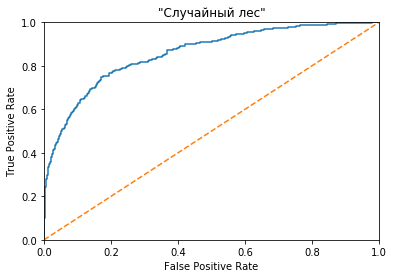

Площадь под кривой =  0.8582805621454679


In [42]:
auc_roc_chart(features_test, target_test, '"Случайный лес"')

<a id='section_id5'></a>

# Вывод

В ходе выполнения работы были проведены следующие операции:
1. На этапе загрузки файла, была проведена небольшая предобработка данных, а именно: удалены столбцы, которые никак не могли влиять на уход клиента из банка (ФИО, ид), кол-во недвижимости (tenure) тоже был удален, т.к. корреляции никакой нет с целевым признаком и там имелись пустые ячейки (удалять строки не стал, т.к. мы можем потерять полезные данные по клиентам).
2. Мы постарались провести машинное обучение к несбалансированным данным. Предсказывали модели 50 на 50 (что нас не устраивало, т.к. в задании стоит точность больше 0,59). Также на данном этапе было обнаружено, что кол-во клиентов которые не собираются покидать банк в 4 раза больше чем тех кто собирается покинуть банк.
3. На данном этапе мы также проводили машинное обучение, но уже с учетом дисбаланса классов. Мы провели технику увеличения выборки (upsample) путем дублирования положительных значений, уменьшения отрицательных выборок (downsample). Лучший результат был получен моделью "Случайный лес" при глбуние дерева max_depth=9, кол-ве деревьев n_estimators=61 f1-мера=0.63 (upsample), что нас вполне устраивает. Также можно было еще побаловаться взвешиванием классов, но сильно в точности мы бы уже не выиграли.
4. Нами заранее была извлечена тестовая выборка (20% от всего датасета). f1-метрика показала на тестовой выборке 0,61. Это больше заданного условия. Площадь под кривой получилась auc_roc = 0,85. Это означаает что наша модель показывает точность.